In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.sparse import csr_matrix

## Spotify recommendation using MinHashing and Gaussian Mixture Models

## Group Members: Kaile Suoo, Jerry Li, Tawhid Ather

## Description


## Data

In [3]:
#download datasets and adjust accordingly
# import pandas as pd

# tracks1 = pd.read_csv('./data/Final Dataset.csv')

# tracks2 = pd.read_csv('./data/tracks_features.csv')

# tracks3 = pd.read_csv('./data/dataset.csv')
# tracks3.rename(columns={'track_id': 'id', 'track_name': 'name'}, inplace=True)

# tracks4 = pd.read_csv('./data/SpotifyFeatures.csv')
# tracks4.rename(columns={'track_id': 'id', 'track_name': 'name'}, inplace=True)

# tracks5 = pd.read_csv('./data/genres_v2.csv')
# tracks5.rename(columns={'song_name': 'name'}, inplace=True)

# tracks6 = pd.read_csv('./data/spotify_data.csv')
# tracks6.rename(columns={'track_id': 'id', 'track_name': 'name'}, inplace=True)

# tracks7 = pd.read_csv('./data/tracks.csv')

# tracks8 = pd.read_csv('./data/spotify_dataset.csv')
# tracks8.rename(columns={'spotify_song_id': 'id', 'title': 'name'}, inplace=True)

# tracks9 = pd.read_csv('./data/Spotify_Song_Attributes.csv')
# tracks9.rename(columns={'trackName': 'name'}, inplace=True)

# tracks10 = pd.read_csv('./data/data.csv')

# all_tracks = pd.concat([tracks1, tracks2, tracks3, tracks4, tracks5, tracks6, tracks7, tracks8, tracks9, tracks10], ignore_index=True)
# all_tracks = all_tracks.drop_duplicates(subset=['id'])
# all_tracks.reset_index(inplace=True)
# all_tracks.columns

# drop = ['tempo','key','mode','instrumentalness', 'duration_ms', 'time_signature','index','genres','Unnamed: 0.1','uri', 'Unnamed: 0', 'id_artists', 'artist','type', 'track_href','analysis_url','error', 'popularity', 'album', 'album_id', 'artists','artist_ids', 'track_number', 'disc_number', 'explicit', 'year','release_date', 'album_name', 'track_genre', 'genre', 'artist_name', 'title', 'spotify_artist_id', 'release_date_precision', 'track_popularity', 'artist_popularity', 'artistName', 'msPlayed']
# all_tracks = all_tracks.drop(columns = drop)
# all_tracks = all_tracks.dropna()
# all_tracks


# all_tracks.to_csv('data/tracks_data.csv', index=False)

In [4]:
tracks_data = pd.read_csv('./data/tracks_data.csv')

In [5]:
tracks_data

,id,name,danceability,energy,loudness,speechiness,acousticness,liveness,valence
0,5tq3Ygbw8ReO3pkehrmdFH,Cumbias del pasado,0.520,0.989,2.121,0.0687,0.3190,0.1250,0.684
1,3XGY5swlPLOmdSuMeuGxol,Babo Barish Kar De Paiso Ki,0.850,0.807,-6.950,0.0465,0.0264,0.1670,0.590
2,3q2cfRnoHTAhiWJgIxQvqA,Asharuwa,0.737,0.729,-9.938,0.3810,0.9330,0.3290,0.940
3,0O9RWQNpRlEcAaf3IEegbY,Limeryki dla odmladzajacych sie,0.426,0.494,-12.883,0.0977,0.5800,0.2580,0.867
4,1djC0yUlRIfEYKlsYDod2V,Okefenokee,0.669,0.732,-7.821,0.0623,0.4710,0.6200,0.814
...,...,...,...,...,...,...,...,...,...
2981440,5Py8zRKGkZvgHniVVtvNCN,All Around Me,0.566,0.438,-7.564,0.0367,0.8090,0.2120,0.692
2981441,3As0OA5B06BxLfADvYyG8L,Stay Tonight,0.636,0.841,-1.927,0.0548,0.1990,0.0836,0.506
2981442,6T78uCv6W58xPrNpS6yZZt,Vibes Only,0.864,0.440,-11.642,0.5530,0.4950,0.3200,0.848
2981443,73C80fhriFzangrzWVO4Zp,Rough Ryder,0.623,0.721,-4.584,0.3390,0.3710,0.1090,0.719


In [6]:
# reads in necessary features from dataset into csv file 
playlists = []
for i in range(0, 1):
    idx = i * 1000
    with open(f'./data/mpd.slice.{idx}-{idx+999}.json', 'r') as file:
        data = json.load(file)
        
        for playlist in data['playlists']:
            playlists.append({
                'pid':playlist['pid'],
                'name':playlist['name'],
                'tracks':[track['track_uri'] for track in playlist['tracks']],
            })
df = pd.DataFrame(playlists)
df['tracks'] = df['tracks'].apply(lambda x: ','.join(x))
df.to_csv('all_playlists.csv', index=False)

In [7]:
df = pd.read_csv('./all_playlists.csv')
df['tracks'] = df['tracks'].apply(lambda x: x.split(','))

print(df.shape)
df

(1000, 3)


,pid,name,tracks
0,0,Throwbacks,"[spotify:track:0UaMYEvWZi0ZqiDOoHU3YI, spotify..."
1,1,Awesome Playlist,"[spotify:track:2HHtWyy5CgaQbC7XSoOb0e, spotify..."
2,2,korean,"[spotify:track:74tqql9zP6JjF5hjkHHUXp, spotify..."
3,3,mat,"[spotify:track:4WJ7UMD4i6DOPzyXU5pZSz, spotify..."
4,4,90s,"[spotify:track:4iCGSi1RonREsPtfEKYj5b, spotify..."
...,...,...,...
995,995,old,"[spotify:track:3Wq1XLo82SODnXJpYHvnyD, spotify..."
996,996,Daze,"[spotify:track:1wZqJM5FGDEl3FjHDxDyQd, spotify..."
997,997,rap,"[spotify:track:48zmVAYyyhoWfTDe5pGynC, spotify..."
998,998,Country,"[spotify:track:4FkgULes13bk2eHrsJg4q9, spotify..."


In [8]:
unique_tracks = set()
for tracks in df['tracks']:
    unique_tracks.update(tracks)
len(unique_tracks)

34443

In [9]:
track_idx = {}
idx_track = {}
for idx, track in enumerate(unique_tracks):
    track_idx[track] = idx
    idx_track[idx] = track

playlist_idx = {}
idx_playlist = {}
for idx, playlist in enumerate(df['pid']):
    playlist_idx[playlist] = idx
    idx_playlist[idx] = playlist

n_playlists = len(df)
n_tracks = len(unique_tracks)

## Minhash

In [10]:
#STEP 1: Characteristic Matrix
row = []
col = []
data = []

for idx, tracks in enumerate(df['tracks']):
    for track in tracks:
        row.append(track_idx[track])
        col.append(idx)
        data.append(1)

dfC = csr_matrix((data, (row, col)), shape=(len(unique_tracks), len(df)))

In [11]:
#STEP 2: Minhash

def minhash(nhash, dfC, Phash): #take given char matrix, nhash, and flesh it out.
    '''
    Takes a number of hash functions to use (nhash) and characteristic matrix (dfC)
    '''
    # use the "universal hash":  (a*x+b) mod p, where a, b are random ints and p > N is prime
    np.random.seed(4022)
    
    Phash = Phash #phash *MUST* be >len(dFC)
    Ahash = np.random.choice(range(0,Phash), size=nhash)
    Bhash = np.random.choice(range(0,Phash), size=nhash)

    # STEP 2:  initialize signature matrix to all infinities
    Msig = np.full([nhash, dfC.shape[1]], fill_value=np.inf)

    # fill in the signature matrix:

    # For each row of the characteristic matrix... 
    hash_vals = [0]*nhash # initialize
    for r in range(dfC.shape[0]):
        # STEP 3:  Compute hash values (~permuted row numbers) for that row under each hash function
        hash_vals = (Ahash * r + Bhash) % Phash
        # STEP 4:  For each column, if there is a 0, do nothing...
            # ... but if there is a 1, replace signature matrix element in that column for each hash fcn 
            # with the minimum of the hash value in this row, and the current signature matrix element
        c = dfC[r].nonzero()[1]
        for h in range(nhash):
            Msig[h, c] = np.minimum(Msig[h, c], hash_vals[h])
    return Msig

In [12]:
nhash = 100
Phash = 2500009

Msig = minhash(nhash, dfC, Phash)

In [83]:
#STEP 3: GET MOST SIMILAR PLAYLISTS

def get_k_similar_playlists(Msig, playlist_idx, k):
    sims = []
    for i in range(Msig.shape[1]):
        if i == playlist_idx:
            sims.append(-1)
        else:
            sims.append(np.sum(Msig[:, playlist_idx] == Msig[:, i]) / Msig.shape[0])

    similar = {}
    while len(similar) < k:
        temp = np.argmax(sims)
        similar[temp] = sims[temp]
        sims[temp] = 0

    return similar

In [1]:
idx = 0
k = 20
similar = get_k_similar_playlists(Msig, idx, k)

print(k, 'most similar to', df.iloc[idx]['name'])
for idx, sim in similar.items():
    print(df.iloc[idx]['name'], ':', sim)

NameError: name 'get_k_similar_playlists' is not defined

## GMM

In [37]:
#STEP 1: get matching songs and audio features from tracks_data

track_ids = set()
for playlist_idx in similar:
    for track in playlists[playlist_idx]['tracks']:
        filtered = track.replace('spotify:track:', '')
        track_ids.add(filtered)
#track_ids

dat = tracks_data[tracks_data['id'].isin(track_ids)]
dat.reset_index(drop=True, inplace=True)
#dat

input_songs_indices = set()
for song in playlists[idx]['tracks']:
    filtered = song.replace('spotify:track:', '')
    if filtered in dat.values:
        index = dat.index[dat['id'] == filtered]
        input_songs_indices.add(index[0])


In [62]:
GMM_DROP = ['acousticness', 'liveness', 'valence', 'id', 'name', 'loudness']
dat1 = dat.drop(columns=GMM_DROP)
dat1

,danceability,energy,speechiness
0,0.593,0.642,0.0299
1,0.677,0.965,0.0426
2,0.847,0.843,0.1060
3,0.641,0.659,0.0857
4,0.778,0.824,0.0712
...,...,...,...
898,0.862,0.488,0.2750
899,0.733,0.856,0.2240
900,0.814,0.782,0.2180
901,0.767,0.782,0.1400


In [63]:
#STEP 2: run GMM

#np.random.seed(4)
#GMM from HW4 sol

def GMM(dat, k, dimension):
    
    #Comments will reference slides 26-31 from Feb 9:
    
    """Define the variables we will use in the Algorithm"""
    #This represents W_m (weights/likelihood of each component) (slide 26)
    p_class=np.zeros(k)
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,dimension))
    
    #This represents Σ_m (covariance matrix) (slide 26)
    covars=np.zeros((k,dimension,dimension))
    
    #This represets p̃_mi (slide 27)
    p_data_given_class=np.zeros((len(dat),k))

    #This is just used at the end to compute mean dist
    mean_dist=np.array(0)
    
    #initializations of initial points (used to set the initial menas lower down)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    #print("INIT_IDX: {}".format(init_idx))
    
    """Initialize means, covs, p_classes"""
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
        
    
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    for step in range(50):  
        
        #print("Step: {}".format(step))
        
        """Expectation Step (Slide 27)"""
        #Bayes stuff: pdfs then pdf*mixtures, then normalize
        
        #For each class (component), compute prob data given class slide 27)
        for dim in range(k):
            #Use pdf to get prob of each data point given component (dim) (slide 27)
            p_data_given_class[:,dim] = stats.multivariate_normal.pdf(x=dat, mean=means[dim], cov=covars[dim])

            #What we have now is P(x_i | cluster = m). We still need to multiply by P(cluster = m)
            
        #Multiply by p_class (slide 27)
        p_class_given_data=p_data_given_class*p_class

        #Now consolidate into probabilities using 1/α_i (slide 27)
        sums=np.sum(p_class_given_data, axis=1)

        for dim in range(k):
            #For each class, divide by the sum to convert to probabilities (slide 27)
            #p_class_given_data now represents p̂_mi
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
            
        # print("\n---Afer Expectation Step---\n p_class_given_data: {}".format(p_class_given_data))
        # print("p_data_given_class: {}".format(p_data_given_class))


        #Now we have completed everything in the Expectation step (slide 27). We'll move on to the maximization step
        
        """Maximization Step (Slide 29-30)"""
        #We'll count the number of points in each component (will be fractional, not whole #)
        #n_class represents n̂_m (Slide 30)
        n_class = np.sum(p_class_given_data, axis=0)

        #Now, we re-compute p_class (which represents W_m, or the weight/likelihood of each class)
        #(See first bullet pt on slide 30)
        p_class=n_class/len(dat)

        #Now we need to do the mean and covariance updates (slide 30)
        for dim in range(k):
            #To compute new means within each class/component (slide 30 bullet pt. 2)
            #1. Sum across: (p_class_given_data * data) = (p̂_mi * x_i)
            #2. Divide by n_class (n̂_m)
            # means[dim,0]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,0])*(1/n_class[dim])
            # means[dim,1]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,1])*(1/n_class[dim])

            for i in range(dimension):
                means[dim, i] = np.sum(p_class_given_data[:, dim] * dat.iloc[:, i]) / n_class[dim]


            
            
            #Now we update the variance/covariance Σ_m by weighted sample covariance (slide 30 bullet pt. 3)
            
            #Make a copy of the data, then subtract the new means
            X_new=dat.copy()
            # X_new.iloc[:,0]=X_new.iloc[:,0]-means[dim,0]
            # X_new.iloc[:,1]=X_new.iloc[:,1]-means[dim,1]
            X_new = dat - means[dim]
                        
            #We can compute the covar matrix for each component as below (slide 30 bullet pt. 3):
            #1. First we'll take the transpose of our new "centered" data (X_new)
            #2. Then we multiply that by our p_class_given_data (p̂_mi)
            #3. Next we do a matrix multiplication between our result from step 2 and X_new (mean centered data)
            #4. Last, we divide by n_class (n̂_m)
                        
                
            # print("m: {}".format(dim))
            # print("X_new: {}".format(X_new))
            # print("p_class_given_data[0]: {}".format(p_class_given_data[0]))
            # print("Components: {}".format(n_class[dim]))
            
            covars[dim,:,:]=np.matmul((np.asarray(X_new).T)*(p_class_given_data[:,dim]),X_new)/(n_class[dim])

            
            #This is an alternate way to compute covars which doesn't utilize np.matmul, and instead uses np.sum in for each entry in 2x2 matrix:
            # covars[dim,0,0]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,0]-means[dim,0])**2))*(1/n_class[dim])
            # covars[dim,1,1]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,1]-means[dim,1])**2))*(1/n_class[dim])                                                      
            # covars[dim,0,1]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,1]-means[dim,1])*(dat.iloc[:,0]-means[dim,0]))*(1/n_class[dim])                                                      
            # covars[dim,1,0]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,1]-means[dim,1])*(dat.iloc[:,0]-means[dim,0]))*(1/n_class[dim])                                                      
    
        
        # print("\n---Afer Maximization step---\n p_class: {}".format(p_class))
        # print("Means: {}".format(means))
        # #print("n_class: {}".format(n_class))
        # print("Covars: {}".format(covars))



    #Once we're done with our for loop, we compute the mean dist (This formula is given below in Part B):
    mean_dist=0
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart
            
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
            #mean_dist+=np.sum((np.array(dat.iloc[pt])-means[dim,:])**2)*p_class_given_data[pt,dim]

    
    mean_dist=mean_dist/(len(dat)*k)
    #mean_dist=np.sqrt(mean_dist/(len(dat)*k))

    
    #Would also be acceptable to do it like this
    #mean_dist=mean_dist/(len(dat))

    
    #Return all the needed variables
    return p_class_given_data, means, covars, p_class, mean_dist

In [65]:
pmi1, mu1, sig1, p1, d1 = GMM(dat1,1,3)
pmi2, mu2, sig2, p2, d2 = GMM(dat1,2,3)
pmi3, mu3, sig3, p3, d3 = GMM(dat1,3,3)
pmi4, mu4, sig4, p4, d4 = GMM(dat1,4,3)
pmi5, mu5, sig5, p5, d5 = GMM(dat1,5,3)
pmi6, mu6, sig6, p6, d6 = GMM(dat1,6,3)
pmi7, mu7, sig7, p7, d7 = GMM(dat1,7,3)
pmi8, mu8, sig8, p8, d8 = GMM(dat1,8,3)


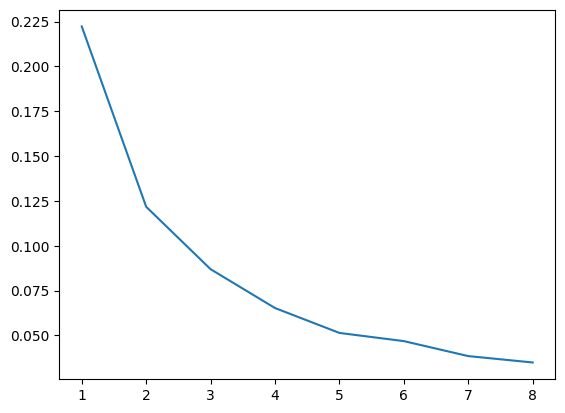

In [66]:
plt.plot([1,2,3,4,5,6,7,8], [d1,d2,d3,d4,d5,d6,d7,d8])

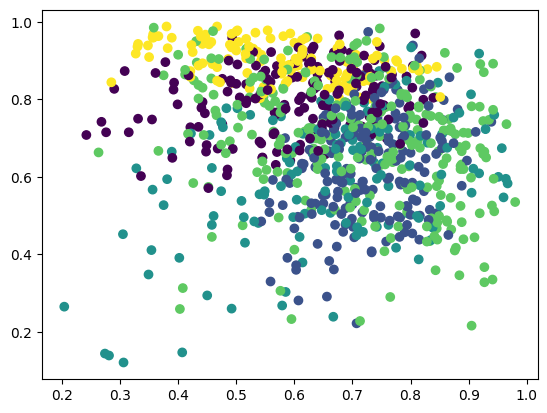

In [70]:
clust_assign = np.argmax(pmi5, axis=1)
#plt.scatter(dat1['speechiness'], dat1['liveness'], c=clust_assign)
plt.scatter(dat1['danceability'], dat1['energy'], c=clust_assign)

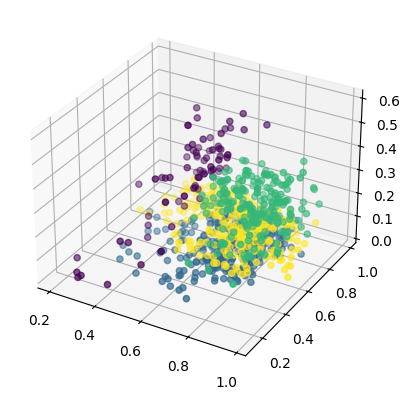

In [79]:
#https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
clust_assign = np.argmax(pmi4, axis=1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(dat1['danceability'], dat1['energy'], dat1['speechiness'],c=clust_assign)

plt.show()



In [80]:
# https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
# import numpy as np
# a = np.arange(6).reshape(2,3) + 10
# a
# array([[10, 11, 12],
#        [13, 14, 15]])
# np.argmax(a)
# 5
# np.argmax(a, axis=0)
# array([1, 1, 1])
# np.argmax(a, axis=1)
# array([2, 2])

def get_top_k_songs(k, pmi, dat, input_song_indices):
    copy_pmi = pmi.copy()

    
    recommendations = []
    probabilities = []

    cluster = 0
    num_clusters = len(copy_pmi[0]) - 1

    while len(recommendations) < k:
        
        if cluster == num_clusters:
            cluster = 0

        highest_indices_from_cluster = np.argmax(copy_pmi, axis=0)

        index = highest_indices_from_cluster[cluster]

        if index not in input_song_indices:
            recommendations.append(index)
            probabilities.append((copy_pmi[index][cluster], cluster))
        else:
            print(index)
        copy_pmi[index][cluster] = 0
        cluster += 1

    most_probable_songs = dat.iloc[recommendations].copy()
    most_probable_songs['probability'] = probabilities

    return most_probable_songs


In [81]:
get_top_k_songs(10, pmi4, dat, input_songs_indices)

355
606


,id,name,danceability,energy,loudness,speechiness,acousticness,liveness,valence,probability
177,2yi7HZrBOC4bMUSTcs4VK6,"Do You Want to Build a Snowman? - From ""Frozen...",0.306,0.121,-15.551,0.0554,0.850,0.2570,0.166,"(0.9999710951876527, 0)"
559,7kSLdGdXLey7pzLsWpdg1h,Little Things,0.707,0.222,-11.716,0.0329,0.788,0.2050,0.556,"(0.9986634330793933, 1)"
498,69bHJ9qs5FrUJbKP8xU8uZ,Disco Inferno,0.925,0.659,-4.763,0.2310,0.206,0.2790,0.710,"(0.9999999372977089, 2)"
175,1lOSxJNCLvWm2bYaTcTSmK,"Mother Knows Best - From ""Tangled""/Soundtrack ...",0.403,0.259,-11.371,0.1660,0.829,0.0451,0.473,"(0.9999560574430224, 0)"
71,4Km5HrUvYTaSUfiSGPJeQR,Bad and Boujee (feat. Lil Uzi Vert),0.927,0.665,-5.313,0.2440,0.061,0.1230,0.175,"(0.9999999101991072, 2)"
173,5k3U0OGYBccHdKJJu3HrUN,"Hakuna Matata - From ""The Lion King""/Soundtrack",0.408,0.313,-18.090,0.1370,0.617,0.1150,0.725,"(0.9998699911313765, 0)"
225,4RCWB3V8V0dignt99LZ8vH,Hey There Delilah,0.656,0.291,-10.572,0.0293,0.872,0.1140,0.298,"(0.9984097797875693, 1)"
102,5cXtT63OTadsjqfRkm5Dwd,Deepthroat,0.930,0.650,-6.896,0.2590,0.184,0.1980,0.403,"(0.9999998695439546, 2)"
89,6LGwYMXXgURfaequXipzHx,You Don't Know My Name,0.263,0.663,-8.264,0.1900,0.589,0.3420,0.250,"(0.9994426119173483, 0)"
31,6Y7Eth6daKj80p4Ofmp6sx,Bruk It Down,0.919,0.781,-4.704,0.2170,0.219,0.2210,0.559,"(0.9999998662743059, 2)"
